데이터

In [1]:
# 필요한 애들 import

import os
import cv2
import keras
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# 데이터 긁어오기 - 생성한 개인 API의 kaggle.json파일 넣어주면 됨
## 그냥 데이터 다운 받아서 업로드 하셔도 되고, 다른 방식으로 kaggle에서 데이터 받아오시기만 해도 됩니당

!pip install kaggle
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c bkai-igh-neopolyp

 98% 309M/314M [00:06<00:00, 83.2MB/s]
100% 314M/314M [00:06<00:00, 54.0MB/s]


In [ ]:
!unzip /content/bkai-igh-neopolyp.zip

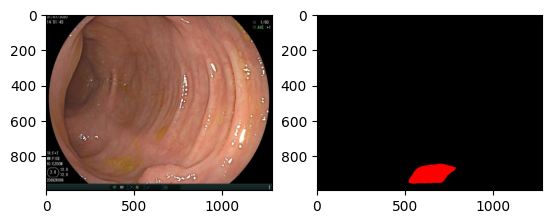

In [6]:
# 어떻게 생겼는지 좀 보면

sample_img_path_x = '/content/train/train/0081835cf877e004e8bfb905b78a9139.jpeg'
sample_img_path_y = '/content/train_gt/train_gt/0081835cf877e004e8bfb905b78a9139.jpeg'
img1 = plt.imread(sample_img_path_x)
img2 = plt.imread(sample_img_path_y)

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(img2)

모델

In [7]:
# DUCK-block 정의 (아키텍처 duck-block.png) - 출처는 논문 깃헙
## 다른 모델 사용할 경우 (u-net 등) 여기부터 수정해주시면 됩니당

from keras.layers import BatchNormalization, add
from keras.layers import Conv2D
kernel_initializer = 'he_uniform'

def conv_block_2D(x, filters, block_type, repeat=1, dilation_rate=1, size=3, padding='same'):
    result = x
    for i in range(0, repeat):
        if block_type == 'separated':
            result = separated_conv2D_block(result, filters, size=size, padding=padding)
        elif block_type == 'duckv2':
            result = duckv2_conv2D_block(result, filters, size=size)
        elif block_type == 'midscope':
            result = midscope_conv2D_block(result, filters)
        elif block_type == 'widescope':
            result = widescope_conv2D_block(result, filters)
        elif block_type == 'resnet':
            result = resnet_conv2D_block(result, filters, dilation_rate)
        elif block_type == 'conv':
            result = Conv2D(filters, (size, size),
                            activation='relu', kernel_initializer=kernel_initializer, padding=padding)(result)
        elif block_type == 'double_convolution':
            result = double_convolution_with_batch_normalization(result, filters, dilation_rate)
        else:
            return None
    return result

def duckv2_conv2D_block(x, filters, size):
    x = BatchNormalization(axis=-1)(x)
    x1 = widescope_conv2D_block(x, filters)
    x2 = midscope_conv2D_block(x, filters)
    x3 = conv_block_2D(x, filters, 'resnet', repeat=1)
    x4 = conv_block_2D(x, filters, 'resnet', repeat=2)
    x5 = conv_block_2D(x, filters, 'resnet', repeat=3)
    x6 = separated_conv2D_block(x, filters, size=6, padding='same')
    x = add([x1, x2, x3, x4, x5, x6])
    x = BatchNormalization(axis=-1)(x)
    return x

def separated_conv2D_block(x, filters, size=3, padding='same'):
    x = Conv2D(filters, (1, size), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (size, 1), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)
    x = BatchNormalization(axis=-1)(x)
    return x

def midscope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', dilation_rate=1)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', dilation_rate=2)(x)
    x = BatchNormalization(axis=-1)(x)
    return x

def widescope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', dilation_rate=1)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', dilation_rate=2)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', dilation_rate=3)(x)
    x = BatchNormalization(axis=-1)(x)
    return x

def resnet_conv2D_block(x, filters, dilation_rate=1):
    x1 = Conv2D(filters, (1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same', dilation_rate=dilation_rate)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x_final = add([x, x1])
    x_final = BatchNormalization(axis=-1)(x_final)
    return x_final

def double_convolution_with_batch_normalization(x, filters, dilation_rate=1):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    return x

In [8]:
# DUCK-net 구축 (아키텍처 duck-net.png)

import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D
from keras.layers import add
from keras.models import Model

kernel_initializer = 'he_uniform'
interpolation = "nearest"

def create_model(img_height, img_width, input_channels, out_classes, starting_filters):
    input_layer = tf.keras.layers.Input((img_height, img_width, input_channels))

    p1 = Conv2D(starting_filters * 2, 2, strides=2, padding='same')(input_layer)
    p2 = Conv2D(starting_filters * 4, 2, strides=2, padding='same')(p1)
    p3 = Conv2D(starting_filters * 8, 2, strides=2, padding='same')(p2)
    p4 = Conv2D(starting_filters * 16, 2, strides=2, padding='same')(p3)
    p5 = Conv2D(starting_filters * 32, 2, strides=2, padding='same')(p4)

    t0 = conv_block_2D(input_layer, starting_filters, 'duckv2', repeat=1)

    l1i = Conv2D(starting_filters * 2, 2, strides=2, padding='same')(t0)
    s1 = add([l1i, p1])
    t1 = conv_block_2D(s1, starting_filters * 2, 'duckv2', repeat=1)

    l2i = Conv2D(starting_filters * 4, 2, strides=2, padding='same')(t1)
    s2 = add([l2i, p2])
    t2 = conv_block_2D(s2, starting_filters * 4, 'duckv2', repeat=1)

    l3i = Conv2D(starting_filters * 8, 2, strides=2, padding='same')(t2)
    s3 = add([l3i, p3])
    t3 = conv_block_2D(s3, starting_filters * 8, 'duckv2', repeat=1)

    l4i = Conv2D(starting_filters * 16, 2, strides=2, padding='same')(t3)
    s4 = add([l4i, p4])
    t4 = conv_block_2D(s4, starting_filters * 16, 'duckv2', repeat=1)

    l5i = Conv2D(starting_filters * 32, 2, strides=2, padding='same')(t4)
    s5 = add([l5i, p5])
    t51 = conv_block_2D(s5, starting_filters * 32, 'resnet', repeat=2)
    t53 = conv_block_2D(t51, starting_filters * 16, 'resnet', repeat=2)

    l5o = UpSampling2D((2, 2), interpolation=interpolation)(t53)
    c4 = add([l5o, t4])
    q4 = conv_block_2D(c4, starting_filters * 8, 'duckv2', repeat=1)

    l4o = UpSampling2D((2, 2), interpolation=interpolation)(q4)
    c3 = add([l4o, t3])
    q3 = conv_block_2D(c3, starting_filters * 4, 'duckv2', repeat=1)

    l3o = UpSampling2D((2, 2), interpolation=interpolation)(q3)
    c2 = add([l3o, t2])
    q6 = conv_block_2D(c2, starting_filters * 2, 'duckv2', repeat=1)

    l2o = UpSampling2D((2, 2), interpolation=interpolation)(q6)
    c1 = add([l2o, t1])
    q1 = conv_block_2D(c1, starting_filters, 'duckv2', repeat=1)

    l1o = UpSampling2D((2, 2), interpolation=interpolation)(q1)
    c0 = add([l1o, t0])
    z1 = conv_block_2D(c0, starting_filters, 'duckv2', repeat=1)

    output = Conv2D(out_classes, (1, 1), activation='sigmoid')(z1)

    model = Model(inputs=input_layer, outputs=output)

    return model

In [9]:
# configs

image_height = 128             # 128, 256, 512 test
image_width = 128
input_channels = 3
out_classes = 3
starting_filters = 17              # 17이랑 34 test

BATCH_SIZE = 4                  # T4 GPU 기준 4 넘어가면 Graph Execution Error 뜨더라고용
NUM_WORKERS = 4
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
BUFF_SIZE = 1000

TRAIN_STEPS = 800//BATCH_SIZE
VALIDATION_STEPS = 200//BATCH_SIZE

In [10]:
ducknet_model = create_model(image_height, image_width, input_channels, out_classes, starting_filters)

In [ ]:
# keras.utils.plot_model(ducknet_model, show_shapes=True)

데이터로더

In [11]:
IMAGE_PATH = '/content/train/train'
MASK_PATH = '/content/train_gt/train_gt'

In [12]:
def load_data(IMAGE_PATH,MASK_PATH):
    images = [os.path.join(IMAGE_PATH, f'{x}') for x in os.listdir(IMAGE_PATH)]
    masks = [os.path.join(MASK_PATH, f'{x}') for x in os.listdir(MASK_PATH)]
    return images, masks

def read_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (image_width, image_height))
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_image_ori(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # image = cv.resize(image, (image_width, image_height))
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(mask_path):
    image = cv2.imread(mask_path)
    image = cv2.resize(image, (image_width, image_height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # lower boundary RED color range values; Hue (0 - 10)
    lower1 = np.array([0, 100, 20])
    upper1 = np.array([10, 255, 255])
    # upper boundary RED color range values; Hue (160 - 180)
    lower2 = np.array([160,100,20])
    upper2 = np.array([179,255,255])
    lower_mask = cv2.inRange(image, lower1, upper1)
    upper_mask = cv2.inRange(image, lower2, upper2)

    red_mask = lower_mask + upper_mask;
    red_mask[red_mask != 0] = 2

    # boundary RED color range values; Hue (36 - 70)
    green_mask = cv2.inRange(image, (36, 25, 25), (70, 255,255))
    green_mask[green_mask != 0] = 1

    full_mask = cv2.bitwise_or(red_mask, green_mask)
    full_mask = full_mask.astype(np.uint8)
    return full_mask

def show_example(image, mask):
    image = image*255 # Get back image pixels
    plt.figure(figsize=(18,15))
    plt.subplot(1,3,1)
    plt.imshow(image[...,1].astype(np.uint8), cmap='bone')
    plt.axis('off')
    plt.title('Image')

    plt.subplot(1,3,2)
    plt.imshow(mask.astype(np.uint8), cmap='nipy_spectral')
    plt.axis('off')
    plt.title('Mask')

    plt.subplot(1,3,3)
    plt.imshow(image[...,1].astype(np.uint8), cmap='bone')
    plt.imshow(mask.astype(np.uint8), alpha=0.5, cmap='nipy_spectral')
    plt.axis('off')
    plt.title('Overlay')

    plt.show()

# Convert numpy data to tensorflow data
'''
We need segent 3 classes:
    + 0 if the pixel is part of the image background (denoted by black color);
    + 1 if the pixel is part of a non-neoplastic polyp (denoted by green color);
    + 2 if the pixel is part of a neoplastic polyp (denoted by red color).
'''
def convert2TfDataset(x, y, batch_size=8):
    def preprocess(image_path, mask_path):
        def f(image_path, mask_path):
            image_path = image_path.decode()
            mask_path = mask_path.decode()
            image = read_image(image_path)
            mask = read_mask(mask_path)
            return image, mask

        image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.uint8])
        mask = tf.one_hot(mask, 3, dtype=tf.uint8)
        image.set_shape([image_height, image_width, 3])
        mask.set_shape([image_height, image_width, 3])
        return image, mask

    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

# Convert numpy data to tensorflow data
'''
We need segent 3 classes:
    + 0 if the pixel is part of the image background (denoted by black color);
    + 1 if the pixel is part of a non-neoplastic polyp (denoted by green color);
    + 2 if the pixel is part of a neoplastic polyp (denoted by red color).
'''
def convert2TfDataset(x, y, batch_size=8):
    def preprocess(image_path, mask_path):
        def f(image_path, mask_path):
            image_path = image_path.decode()
            mask_path = mask_path.decode()
            image = read_image(image_path)
            mask = read_mask(mask_path)
            return image, mask

        image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.uint8])
        mask = tf.one_hot(mask, 3, dtype=tf.uint8)
        image.set_shape([image_height, image_width, 3])
        mask.set_shape([image_height, image_width, 3])
        return image, mask

    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

In [13]:
images, masks = load_data(IMAGE_PATH, MASK_PATH)
print(f'Amount of images: {len(images)}')
train_x, valid_x, train_y, valid_y = train_test_split(images, masks, test_size=0.2, random_state=42)    ## test_size 0.2에서 0.1로 바꿔서 돌려보기

print(f'Training: {len(train_x)} - Validation: {len(valid_x)}')

Amount of images: 1000
Training: 800 - Validation: 200


In [14]:
train_step = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_step += 1

valid_step = len(valid_x)//BATCH_SIZE
if len(valid_x) % BATCH_SIZE != BATCH_SIZE:
    valid_step += 1

train_dataset = convert2TfDataset(train_x, train_y, BATCH_SIZE)
valid_dataset = convert2TfDataset(valid_x, valid_y, BATCH_SIZE)

컴파일

In [15]:
# metric 정의 (dice_coef)

from keras import backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [16]:
ducknet_model.compile(optimizer=keras.optimizers.Adam(learning_rate = LEARNING_RATE), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])

In [17]:
## 저는 다시 빌드하는 게 번거로워서 weight 말고 model 자체 저장했는데
## 저장이랑 불러오기 너무 느려서 번거로우시면 weight 파일만 저장하는 방식으로 코드 수정하셔도 좋을 것 같아용

filepath = 'model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Training

In [ ]:
# 드라이브에서 중간저장한 모델 가져올 경우 (training 중간에 끊겼던 거 다시 불러오려고 하는 경우)
## 최초 training일 경우 불필요하니 스킵

ducknet_model = keras.models.load_model('/content/drive/MyDrive/model.h5', custom_objects={"dice_coef": dice_coef})

In [ ]:
## 실제 training

hist = ducknet_model.fit(train_dataset, validation_data=valid_dataset,
                                      epochs=NUM_EPOCHS,
                                      batch_size = BATCH_SIZE,
                                      workers=NUM_WORKERS,
                                      verbose=1,
                                      steps_per_epoch=TRAIN_STEPS,
                                      validation_steps=VALIDATION_STEPS,
                                      callbacks=[checkpoint])

In [ ]:
fig = plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), hist.history['loss'], label='training loss')
plt.plot(np.arange(8, NUM_EPOCHS), hist.history['val_loss'][8:NUM_EPOCHS], label='validation loss')
plt.plot(np.arange(0, NUM_EPOCHS), hist.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, NUM_EPOCHS), hist.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [ ]:
## 구글 드라이브에 model.h5 저장하는 부분 (training 중 중간저장, 아예 모델 완성되어 저장 두 경우 모두)
## 안 하셔도 상관 없는데, 런타임에 있는 model.h5 로컬로 내려받는 데 시간 엄청엄청 오래 걸려요,, 저는 드라이브 사용합니당

import shutil
shutil.copy('/content/model.h5', '/content/drive/MyDrive/model.h5')

Prediction

In [ ]:
# 드라이브에서 model.h5를 불러와야 하는 경우
## 런타임 초기화 후, training 필요 없이 드라이브에 있는 model 불러와서 inference만 해보고 싶은 경우입니당

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 드라이브에서 model.h5를 불러와야 하는 경우

MODEL = keras.models.load_model('/content/drive/MyDrive/model.h5', custom_objects={"dice_coef": dice_coef})

In [ ]:
# 그게 아니라 런타임에 있는 model.h5 사용하는 경우
## 사실 아래 셀의 MODEL을 ducknet_model로 고쳐주시면 이 부분 실행 불필요

MODEL = keras.models.load_model('/content/model.h5', custom_objects={"dice_coef": dice_coef})

In [23]:
# inference 결과들 저장할 디렉토리 만들고 (없으면 에러 발생 안시키고 소리소문없이 아무 일도 일어나지 않음)

import shutil
shutil.rmtree('/content/submissions')
os.mkdir('submissions')

In [ ]:
!pip install datasets

In [ ]:
from tensorflow import keras
from tqdm import tqdm
import os
from PIL import Image as im
import numpy as np
import imageio
import cv2
test_images = [os.path.join('/content/test/test', f'{x}') for x in os.listdir('/content/test/test')]

color_dict = {0: (0, 0, 0),
              1: (0, 255, 0),
              2: (255, 0, 0)}

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)
colors = np.array([[0, 0, 0],
                       [0, 255, 0],
                       [0, 0, 255]])

for image in tqdm(test_images):
    '''
    We need segent 3 classes:
        + 0 if the pixel is part of the image background (denoted by black color);
        + 1 if the pixel is part of a non-neoplastic polyp (denoted by green color);
        + 2 if the pixel is part of a neoplastic polyp (denoted by red color).
    '''
    save_name = image.split('/')[-1].replace('.jpeg','.png')
    original_image = cv2.imread(image) * 255
    h, w, c = original_image.shape
    x = read_image(image)
    p = MODEL.predict(np.expand_dims(x, axis=0))[0]  #256,256,3   # 여기에서 MODEL을 ducknet_model로 바꾸면 모델 로드 불필요, 바로 training 되던 애로 inference 가능
    show_img = False
    if show_img: #False
        p = np.argmax(p, axis=-1) # 995,1280
        rgb = np.zeros((*p.shape, 3))
        for label, color in enumerate(colors):
            rgb[p == label] = color
        show_example(x, rgb)
    else:
        p = cv2.resize(p.astype(np.float32), ( w , h ), cv2.INTER_CUBIC) #995,1280,3
        p = np.argmax(p, axis=-1) # 995,1280
        # print(np.unique(p))
        # p_rgb = onehot_to_rgb(p,color_dict)
        rgb = np.zeros((*p.shape, 3)).astype(np.uint8)
        for label, color in enumerate(colors):
            rgb[p == label] = color
        cv2.imwrite('/content/submissions'+'/'+save_name, rgb)

Submission

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded

    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        # 여기에서 size 다시 input이랑 맞춰주고
        # img = cv2.resize(img, (256, 256))
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/content/submissions'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)